In [1]:
import numpy as np
from lxml import etree as ET
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import requests
import random
import tqdm
from concurrent.futures import ThreadPoolExecutor
import time

In [2]:
def fetch_xml_from_url(url):
    try:
        response = requests.get(url)
        url1=response.url
        if response.status_code==429:
            retry_after = int(response.headers['Retry-After'])
            print('429 error, retry after', retry_after)
            time.sleep(retry_after+10)
            return fetch_xml_from_url(url)
        if response.status_code != 200:
            print('Error fetching xml from url')
            print("URL: ", url)
            print("Status code: ", response.status_code)
            #print("Response: ", response.content)
            return None
        if url1.endswith('.html'):
            url1=url1.replace('.html','.xml')
            return fetch_xml_from_url(url1)
        return ET.fromstring(response.content)
    except Exception as e:
        print(e)
        print('Error fetching xml from url')
        print("URL: ", url)
        print("Status code: ", response.status_code)
        #print("Response: ", response.content)
        return None
def is_disambiguation(xml):
    person_element = xml.find(".//person")
    if person_element is not None:
        publtype = person_element.get("publtype")
        return publtype == "disambiguation"
    return False

In [3]:
ori_data= pd.read_excel("DataScientists.xls")
ori_data['expertise'] = np.random.randint(1, 11, ori_data.shape[0])
ori_data

,name,country,institution,dblp,expertise
0,aaron elmore,united states,university of chicago,https://dblp.org/pers/e/Elmore:Aaron_J=.html,4
1,abdalghani abujabal,germany,amazon alexa,https://dblp.org/pers/a/Abujabal:Abdalghani.html,6
2,abdul quamar,united states,ibm research almaden,https://dblp.org/pers/q/Quamar:Abdul.html,7
3,abdulhakim qahtan,netherlands,utrecht university,https://dblp.org/pid/121/4198.html,10
4,abhijnan chakraborty,germany,max planck institute for software systems,https://dblp.org/pers/c/Chakraborty:Abhijnan.html,5
...,...,...,...,...,...
1215,zixian huang,china,nanjing university,https://dblp.uni-trier.de/pers/hd/h/Huang:Zixian,5
1216,zoi kaoudi,qatar,qatar computing research institute,https://dblp.org/pers/k/Kaoudi:Zoi.html,9
1217,zoi kaoudi,germany,tu berlin,https://dblp.org/pers/k/Kaoudi:Zoi.html,5
1218,zsolt istvan,germany,tu darmstadt,https://dblp.org/pid/50/10703.html,1


In [4]:
pids=[]
pid_xml={}
def single_xml(url):
    global pids,pid_xml
    if url.endswith('.html'):
        url=url.replace('.html','.xml')
    elif not url.endswith('.xml'):
        url=url+'.xml'
    xml=fetch_xml_from_url(url)
    if xml is not None:
        if not is_disambiguation(xml):
            pid=xml.xpath('//dblpperson')[0].attrib['pid']
            pids.append(pid)
            pid_xml[pid]=xml
        else:
            pids.append(None)
    else:
        pids.append(None)
processbar=tqdm.tqdm(total=ori_data.shape[0])
url_list=ori_data["dblp"].to_list()
for url in url_list:
    single_xml(url)
    processbar.update(1)

  0%|          | 6/1220 [00:05<19:27,  1.04it/s]

Error fetching xml from url
URL:  https://dblp.org/pid/39/1380.xml
Status code:  410


  5%|▍         | 56/1220 [01:01<25:06,  1.29s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/c/Chakraborty:Anirban.xml
Status code:  410


 12%|█▏        | 148/1220 [02:41<18:34,  1.04s/it]

Error fetching xml from url
URL:  https://dblp.org/pid/92/2769.xml
Status code:  404


 12%|█▏        | 149/1220 [02:42<18:15,  1.02s/it]

Error fetching xml from url
URL:  https://dblp.org/pid/148/7268.xml
Status code:  410


 18%|█▊        | 214/1220 [03:59<20:29,  1.22s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/b/Barbosa:Denilson.xml
Status code:  410


 18%|█▊        | 216/1220 [04:01<19:07,  1.14s/it]

Error fetching xml from url
URL:  https://dblp.org/pers/g/Georgakopoulos:Dimitrios.xml
Status code:  410


 18%|█▊        | 225/1220 [04:12<17:13,  1.04s/it]

Error fetching xml from url
URL:  https://dblp.org/pid/161/0102.xml
Status code:  410


 22%|██▏       | 263/1220 [04:52<13:54,  1.15it/s]

Error fetching xml from url
URL:  https://dblp.org/pers/m/Mansour:Essam.xml
Status code:  410


 22%|██▏       | 264/1220 [04:53<14:06,  1.13it/s]

Error fetching xml from url
URL:  https://dblp.org/pers/m/Mansour:Essam.xml
Status code:  410


 24%|██▎       | 289/1220 [05:23<17:08,  1.10s/it]

Error fetching xml from url
URL:  https://dblp.org/pid/284/0968.xml
Status code:  404


 30%|███       | 367/1220 [06:47<15:38,  1.10s/it]

Error fetching xml from url
URL:  https://dblp.org/pid/98/5721.xml
Status code:  410


 32%|███▏      | 392/1220 [07:12<13:53,  1.01s/it]

Error fetching xml from url
URL:  https://dblp.org/pers/j/Jung:Hyungsoo.xml
Status code:  410


 32%|███▏      | 396/1220 [07:17<15:12,  1.11s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/p/Petrov:Ilia.xml
Status code:  410


 33%|███▎      | 397/1220 [07:18<14:05,  1.03s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/p/Petrov:Ilia.xml
Status code:  410


 42%|████▏     | 511/1220 [09:39<11:02,  1.07it/s]

Error fetching xml from url
URL:  https://dblp.org/pers/h/Hui:Kai.xml
Status code:  410


 52%|█████▏    | 631/1220 [12:08<09:29,  1.03it/s]

Error fetching xml from url
URL:  https://dblp.org/pers/w/Weidlich:Matthias.xml
Status code:  410


 55%|█████▍    | 667/1220 [12:49<11:25,  1.24s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/hd/n/Nikolic:Milos.xml
Status code:  410


 72%|███████▏  | 879/1220 [16:57<07:02,  1.24s/it]

Error fetching xml from url
URL:  https://dblp.org/pers/z/Zhang:Ruqing.xml
Status code:  410


 82%|████████▏ | 1000/1220 [20:24<04:19,  1.18s/it] 

Error fetching xml from url
URL:  https://dblp.dagstuhl.de/pid/y/TingYu.xml
Status code:  410


 82%|████████▏ | 1001/1220 [20:25<04:00,  1.10s/it]

Error fetching xml from url
URL:  https://dblp.dagstuhl.de/pid/y/TingYu.xml
Status code:  410


 97%|█████████▋| 1188/1220 [25:13<00:36,  1.15s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/t/Tao:Yufei.xml
Status code:  410


 97%|█████████▋| 1189/1220 [25:14<00:33,  1.08s/it]

Error fetching xml from url
URL:  https://dblp.uni-trier.de/pers/t/Tao:Yufei.xml
Status code:  410


100%|██████████| 1220/1220 [26:02<00:00,  1.32s/it]

In [5]:
ori_data['pid']=pids

In [7]:
#drop the rows that pid is None
ori_data=ori_data.dropna(subset=['pid'])

,name,country,institution,dblp,expertise,pid
0,aaron elmore,united states,university of chicago,https://dblp.org/pers/e/Elmore:Aaron_J=.html,4,75/9436
1,abdalghani abujabal,germany,amazon alexa,https://dblp.org/pers/a/Abujabal:Abdalghani.html,6,162/9092
2,abdul quamar,united states,ibm research almaden,https://dblp.org/pers/q/Quamar:Abdul.html,7,127/6195
3,abdulhakim qahtan,netherlands,utrecht university,https://dblp.org/pid/121/4198.html,10,121/4198
4,abhijnan chakraborty,germany,max planck institute for software systems,https://dblp.org/pers/c/Chakraborty:Abhijnan.html,5,116/1678
...,...,...,...,...,...,...
1215,zixian huang,china,nanjing university,https://dblp.uni-trier.de/pers/hd/h/Huang:Zixian,5,247/5762
1216,zoi kaoudi,qatar,qatar computing research institute,https://dblp.org/pers/k/Kaoudi:Zoi.html,9,65/1457
1217,zoi kaoudi,germany,tu berlin,https://dblp.org/pers/k/Kaoudi:Zoi.html,5,65/1457
1218,zsolt istvan,germany,tu darmstadt,https://dblp.org/pid/50/10703.html,1,50/10703


In [31]:
ori_data.to_csv('cleaned_data.csv',index=False)

In [20]:
r_list=[]
pids=list(pid_xml.keys())
idx=[i for i in range(len(pids))]
pid_idx=dict(zip(pids,idx))
inv_pid_idx=dict(zip(idx,pids))
for pid in pid_xml:
    x=pid_xml[pid]
    r1=x.xpath('//r')
    r_list.extend(r1)

In [26]:
pb=tqdm.tqdm(total=len(r_list))
year_edges={}
for r in r_list:
    authors=r.xpath('.//author')
    year=r.xpath('.//year')[0].text
    authors_pid=[author.attrib['pid'] for author in authors]
    if len(authors)>1:
        for i in range(len(authors_pid)):
            for j in range(i+1,len(authors_pid)):
                if authors_pid[i] in pids and authors_pid[j] in pids:
                    if year not in year_edges:
                        year_edges[year]=[]
                    if (authors_pid[i],authors_pid[j]) not in year_edges[year] and (authors_pid[j],authors_pid[i]) not in year_edges[year]:
                        year_edges[year].append((pid_idx[authors_pid[i]],pid_idx[authors_pid[j]]))
    pb.update(1)             


100%|██████████| 127830/127830 [01:52<00:00, 1136.61it/s]

100%|█████████▉| 127791/127830 [00:24<00:00, 3331.59it/s]

In [46]:
for year in year_edges:
    year_edges[year]=list(set(year_edges[year]))
    for e in year_edges[year]:
        if (e[1],e[0]) in year_edges[year]:
            year_edges[year].remove((e[1],e[0]))
    print(year,len(year_edges[year]))

2024 320
2023 1579
2022 1850
2021 1266
2020 1421
2019 1644
2018 1264
2017 1184
2016 1269
2015 1103
2014 1122
2013 815
2012 760
2011 690
2010 592
2008 614
2007 405
2009 686
2006 353
2005 355
2004 278
2003 266
2000 104
1998 71
2002 152
2001 121
1999 85
1997 56
1995 32
1994 29
1993 20
1996 34
1992 8
1991 9
1990 10
1989 4
1988 4
1986 3
1982 2
1984 3
1987 1


In [61]:
with open('year_edges.pkl','wb') as f:
    pickle.dump(year_edges,f)
with open('pid_idx.pkl','wb') as f:
    pickle.dump(pid_idx,f)
with open('inv_pid_idx.pkl','wb') as f:
    pickle.dump(inv_pid_idx,f)

In [48]:
edges=[]
for year in year_edges:
    edges.extend(year_edges[year])
edges=list(set(edges))

In [49]:
for e in edges:
    if (e[1],e[0]) in edges:
        edges.remove((e[1],e[0]))

In [50]:
G=nx.Graph()
for idx in inv_pid_idx:
    G.add_node(idx)
G.add_edges_from(edges)

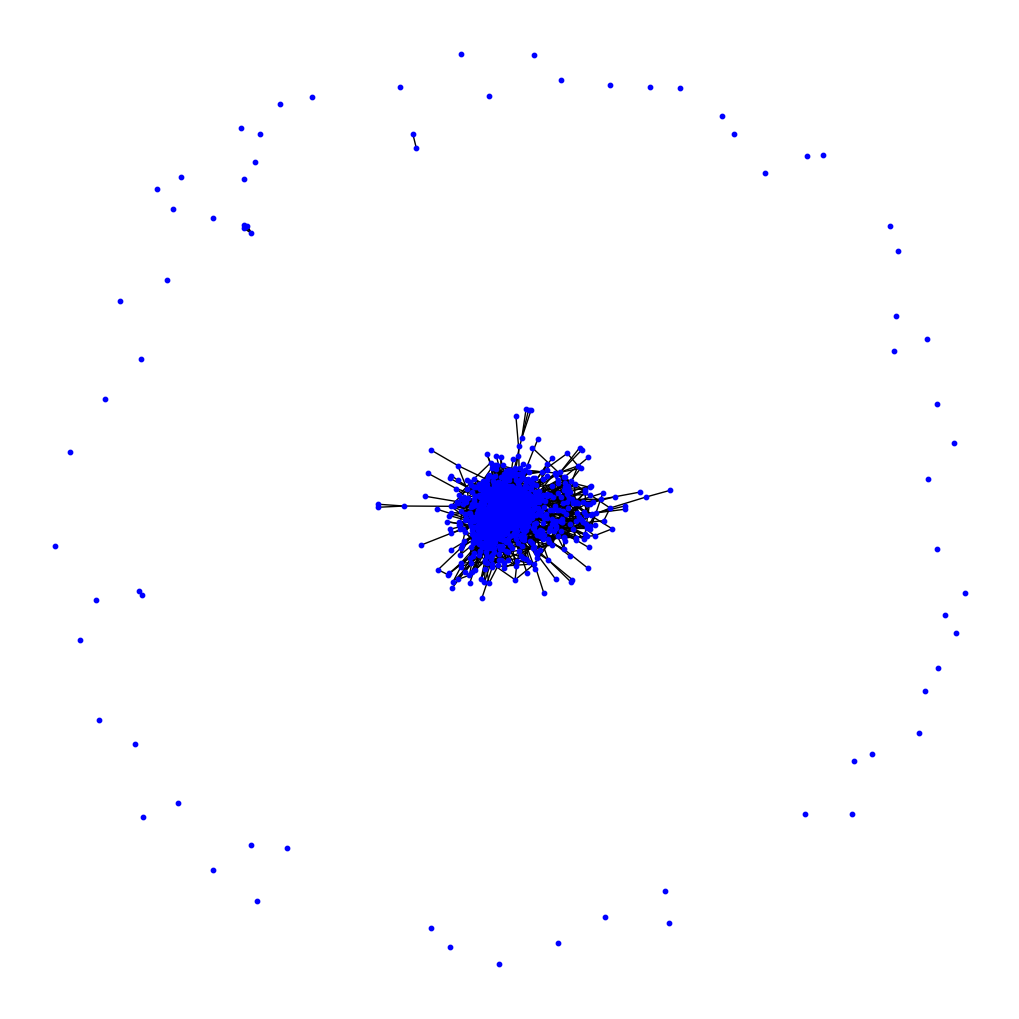

In [51]:
#draw the graph
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=10, node_color="blue", with_labels=False)
plt.savefig('graph.png')

In [55]:
#graph analysis
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
print("Average clustering coefficient: ", nx.average_clustering(G))
print('Average degree:', sum(dict(G.degree()).values())/G.number_of_nodes())
print('Number of connected components:', nx.number_connected_components(G))
print('Size of largest connected component:', len(max(nx.connected_components(G), key=len)))

Number of nodes:  1028
Number of edges:  7327
Average clustering coefficient:  0.3043159815248051
Average degree: 14.254863813229573
Number of connected components: 69
Size of largest connected component: 955


In [57]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count={}
for d in degree_sequence:
    if d not in degree_count:
        degree_count[d]=0
    degree_count[d]+=1
degree_count

{98: 1,
 94: 1,
 93: 1,
 91: 1,
 90: 1,
 88: 1,
 87: 1,
 83: 1,
 81: 1,
 78: 1,
 77: 1,
 76: 1,
 75: 1,
 73: 1,
 70: 2,
 69: 2,
 68: 3,
 67: 1,
 66: 1,
 65: 2,
 64: 1,
 63: 1,
 62: 1,
 61: 5,
 60: 2,
 59: 1,
 58: 3,
 57: 1,
 56: 4,
 54: 2,
 52: 2,
 51: 2,
 50: 3,
 49: 1,
 48: 2,
 47: 1,
 46: 3,
 45: 7,
 44: 3,
 43: 6,
 42: 2,
 41: 5,
 40: 2,
 39: 5,
 38: 3,
 37: 5,
 36: 1,
 35: 4,
 34: 5,
 33: 6,
 32: 7,
 31: 7,
 30: 14,
 29: 2,
 28: 7,
 27: 12,
 26: 6,
 25: 9,
 24: 11,
 23: 15,
 22: 14,
 21: 9,
 20: 19,
 19: 18,
 18: 18,
 17: 14,
 16: 21,
 15: 19,
 14: 19,
 13: 29,
 12: 26,
 11: 38,
 10: 34,
 9: 32,
 8: 38,
 7: 41,
 6: 54,
 5: 60,
 4: 55,
 3: 82,
 2: 59,
 1: 60,
 0: 65}

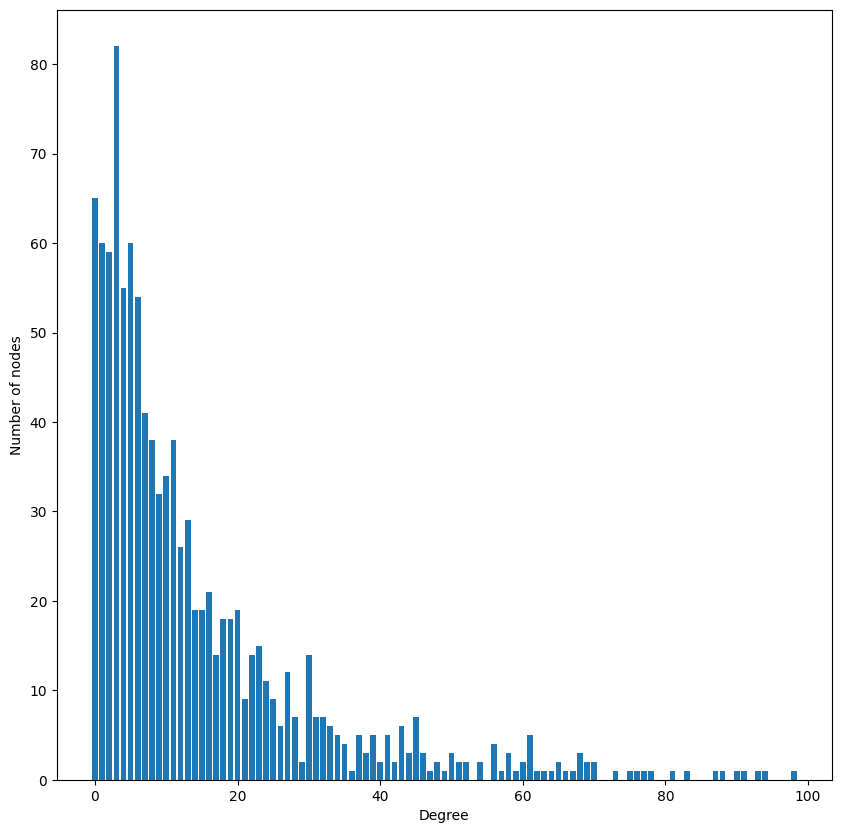

In [60]:
plt.figure(figsize=(10,10))
plt.bar(degree_count.keys(),degree_count.values())
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.show()
#plt.savefig('degree_distribution.png')